# Meta-learn optimal weight sharing in MLP

Here is an idea to find “the optimal weight sharing” in a one linear layer:
Let the weights of linear layer be w \in R^n. Let v \in R^k be the vector of all unique weights (k unique weights).
during training we calculate w with w=Av, essentially taking linear combination of v_1,…, v_k.
However we soft enforce (with a loss function) that the rows of A have low entropy (pick a single unique weight) and/or rows of A prefer v_1, v_2, etc. more than v_1000, v_1001, etc… (to use as few unique weights as possible)
We train over the matrix A and the unique weights v.
The resulting weight vector w will be in some sense the optimal weight sharing version of w.
We can analyze which weights are learned to be shared by looking at rows of A.
My hope is that it can recover CNN weight sharing or transformer weight sharing or some other human interpretable weight sharing that may give insight into how to engineer inductive biases in the future.
Maybe it finds optimal inductive bias for images.

In [1]:
import mnist

import torch
from torch import nn
import numpy as np

from tqdm.notebook import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
m = mnist.MNIST()

/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
A = torch.randn(28*28, 500)

v = torch.randn(500)
# w.shape, v.shape

In [5]:
Ap = A.softmax(dim=-1)
w = Ap@v
w.shape

torch.Size([784])

In [6]:
torch.distributions.Categorical(probs=Ap).entropy().mean()

tensor(5.7187)

In [64]:
class Net(nn.Module):
    def __init__(self, hidden_sizes=[100], nonlin=torch.relu):
        super().__init__()
        hidden_sizes = [28*28] + hidden_sizes + [10]
        self.hidden_sizes = hidden_sizes

        
        self.weights = [torch.randn(o, i+1)*0.01 for o, i in zip(hidden_sizes[1:], hidden_sizes[:-1])]
        self.weights = nn.ParameterList([nn.Parameter(w) for w in self.weights])
        
#         for w in self.weights:
#             print(w.shape)
            
        self.nonlin = nonlin
        
    def forward(self, x):
        x = x.reshape(len(x), -1)
        for wb in self.weights:
            w, b = wb[:, :-1], wb[:, -1]
            x = x@w.T+b
            
            x = self.nonlin(x)
#             x = x+y if x.shape==y.shape else y
        return x

class SharedNet(nn.Module):
    def __init__(self, hidden_sizes=[100], ks=[10, 10], nonlin=torch.relu):
        super().__init__()
        hidden_sizes = [28*28] + hidden_sizes + [10]
        self.hidden_sizes = hidden_sizes
        
        self.As = [torch.randn(o*(i+1), k)*0.0001 for o, i, k in zip(hidden_sizes[1:], hidden_sizes[:-1], ks)]
        self.vs = [torch.randn(k)*0.01 for k in ks]
        
        self.As = nn.ParameterList([nn.Parameter(A) for A in self.As])
        self.vs = nn.ParameterList([nn.Parameter(v) for v in self.vs])
        
#         for w in self.weights:
#             print(w.shape)
            
        self.nonlin = nonlin
        
    def forward(self, x):
        x = x.reshape(len(x), -1)
        for A, v, i, o in zip(self.As, self.vs, self.hidden_sizes[:-1], self.hidden_sizes[1:]):
            A = (A/10.).softmax(dim=-1)
            wb = A@v
            wb = wb.reshape(o, i+1)
            
            w, b = wb[:, :-1], wb[:, -1]
            x = x@w.T+b
            
            x = self.nonlin(x)
#             x = x+y if x.shape==y.shape else y
        return x
    
    
net = Net([100,30])
print(np.sum([p.numel() for p in net.parameters()]))
net = SharedNet([100,30], [100, 100])
net = SharedNet([100,30], [10, 10])
print(np.sum([p.numel() for p in net.parameters()]))

# net(torch.randn(100, 28*28)).shape
    

81840
815320


In [70]:
net.As[0].data.detach().cpu().abs().max()

tensor(0.0005)

In [59]:
net = net.to(device)

In [60]:
loss_function = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)

In [61]:
def calc_ds_stats(net, loader):
    losses = []
    accs = []
    for batch_idx, (X_batch, Y_batch) in enumerate(loader):
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        Y_batch_pred = net(X_batch)
        loss = loss_function(Y_batch_pred, Y_batch)
        losses.append(loss.item())
        Y_batch_pred_idx = Y_batch_pred.argmax(dim=-1)
        acc = (Y_batch_pred_idx==Y_batch).sum().item()/len(Y_batch)
        accs.append(acc)
    return np.average(losses), np.average(accs)

In [62]:
calc_ds_stats(net, m.loader_test)

(3.4011974930763245, 0.11083333333333333)

In [63]:
losses = []
for epoch_idx in tqdm(range(10)):
    print('Epoch ', epoch_idx)
    for batch_idx, (X_batch, Y_batch) in tqdm(enumerate(m.loader_test), total=len(m.loader_test)):
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
#         X_batch, Y_batch = X, Y
        Y_batch_pred = net(X_batch)
        loss = loss_function(Y_batch_pred, Y_batch)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        
        g = torch.cat([p.grad.flatten() for p in net.parameters()])
        print(g.abs().min().item(), g.abs().mean().item(), g.abs().max().item())
        
#     plt.plot(losses);plt.show() 
    print(calc_ds_stats(net, m.loader_test))


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch  0


  0%|          | 0/4 [00:00<?, ?it/s]

1.3395002563752872e-20 1.3025013956280418e-08 9.693863830761984e-06
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
(3.4011974930763245, 0.09783333333333333)
Epoch  1


  0%|          | 0/4 [00:00<?, ?it/s]

0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
(3.4011974930763245, 0.09833333333333333)
Epoch  2


  0%|          | 0/4 [00:00<?, ?it/s]

0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0


KeyboardInterrupt: 

In [32]:
calc_ds_stats(net, m.loader_test)

(0.5778536349534988, 0.8353333333333334)

In [40]:
import matplotlib.pyplot as plt

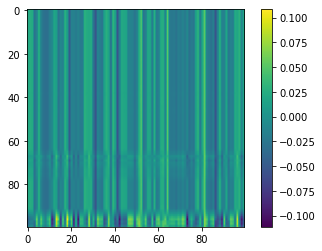

In [56]:
plt.imshow(net.As[0].detach().cpu().numpy()[:100])
plt.colorbar()

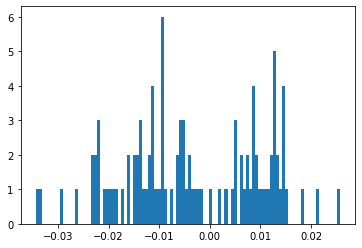

In [45]:
plt.hist(net.vs[0].data.cpu().numpy(), bins=100);

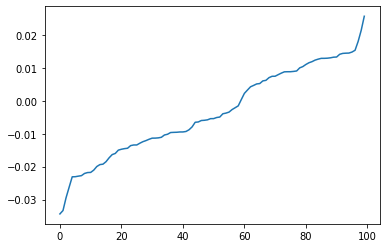

In [48]:

plt.plot(net.vs[0].data.cpu().sort().values.numpy());